In [1]:
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
NORMAL = -.1
TREASURE = 2
OBSTICLE = .5
OPPONENT = -2

In [3]:
height = 15
width = 15

M = np.full((width,height), NORMAL)
shape = M.shape
M = M.flatten()
np.random.seed(5)
treasureIndecies = np.random.choice(M.size, size=15)
M[treasureIndecies] = TREASURE
M = M.reshape(shape)

M[1][0] = TREASURE; M[2][1] = TREASURE; M[3][2] = TREASURE; M[4][3] = TREASURE

M[5,1] = OBSTICLE; M[6,1] = OBSTICLE; M[7,1] = OBSTICLE; M[8,1] = OBSTICLE
M[11,1] = OBSTICLE; M[12,1] = OBSTICLE; M[13,1] = OBSTICLE; M[14,1] = OBSTICLE
M[11,2] = OBSTICLE; M[11,3] = OBSTICLE; M[11,4] = OBSTICLE; M[11,5] = OBSTICLE

M[10,4] = OPPONENT; M[4,3] = OPPONENT; M[5,10] = OPPONENT; M[14,4] = OPPONENT

M[0,0] = NORMAL
M[14,14] = TREASURE

In [4]:
start_state = 0
state_count = M.size
final_state = state_count - 1
move_options = 4
exploitation_probability = .8

In [5]:
Q = np.zeros(shape=[state_count,move_options], dtype=np.float32)  # Quality

In [6]:
gamma = .5
lrn_rate = .2
max_epochs = 5000
max_steps = 100

In [7]:
def move_state(state, move):
    if move == 0:   # North
        return state - width
    elif move == 1: # East
        return state + 1
    elif move == 2: # South
        return state + width
    elif move == 3: # West
        return state - 1
    else:
        raise Exception

In [8]:
def get_poss_moves(s, M):
    poss_moves = []
    valid_moves = []
    x, y = stateToXY(s)
    if y > 0:
        valid_moves.append(0)
    if x < len(M[0]) - 1:
        valid_moves.append(1)
    if y < len(M) - 1:
        valid_moves.append(2)
    if x > 0:
        valid_moves.append(3)
    for move in valid_moves:
            poss_state = move_state(s,move)
            x,y = stateToXY(poss_state)
            if M[y][x] != OBSTICLE: poss_moves.append(move)
    return poss_moves
def get_best_next_move(s, M, Q):
    poss_next_moves = get_poss_moves(s, M)
    if len(poss_next_moves) == 0:
            return None
    max_m = poss_next_moves[0]
    max_q = Q[s][max_m]

    for move in poss_next_moves[1::]:
        if(Q[s][move] > max_q):
            max_q, max_m = Q[s][move], move
    return max_m

def get_rnd_next_move(s, M, Q):
    poss_next_moves = get_poss_moves(s, M)
    if len(poss_next_moves) == 0:
            return None
    if np.random.rand() <= exploitation_probability:
        return get_best_next_move(s, M, Q)
    else:
        next_move = \
            poss_next_moves[np.random.randint(0,\
            len(poss_next_moves))]
        return next_move

In [9]:
def stateToXY(s):
    return s % width, s // width
def XYToState(x,y):
    return y*width+x

In [10]:
def train(M, Q, gamma, lrn_rate, goal, ns, max_epochs, startingState, max_steps):
    for _ in range(0,max_epochs):
        M_copy = np.copy(M)
        curr_s = 0
        steps = 0
        x,y = stateToXY(curr_s)
        points = M_copy[y][x]
        M_copy[y][x] = OBSTICLE
        while(True):
            next_m = get_rnd_next_move(curr_s, M_copy, Q)
            if next_m is None:
                break
            next_s = move_state(curr_s,next_m)
            x,y = stateToXY(next_s)
            next_r = M_copy[y][x]
            points += next_r

            M_copy[y][x] = OBSTICLE

            bestnextnextMove = get_best_next_move(next_s, M_copy, Q)
            max_Q = -1
            if bestnextnextMove is not None:
                max_Q = Q[next_s][bestnextnextMove]
                
            Q[curr_s][next_m] = Q[curr_s][next_m] + (lrn_rate) * \
                                                    ( next_r + (gamma * max_Q) - Q[curr_s][next_m] )
            curr_s = next_s
            steps += 1
            if curr_s == goal: break
            if steps == max_steps: break

Path from (0, 0) to (14, 14)
(0, 0)->(0, 1)->(0, 2)->(1, 2)->(1, 3)->(2, 3)->(2, 2)->(2, 1)->(2, 0)->(3, 0)->(4, 0)->(5, 0)->(6, 0)->(7, 0)->(8, 0)->(9, 0)->(9, 1)->(9, 2)->(9, 3)->(9, 4)->(9, 5)->(9, 6)->(9, 7)->(9, 8)->(9, 9)->(8, 9)->(8, 10)->(9, 10)->(9, 11)->(9, 12)->(9, 13)->(10, 13)->(10, 12)->(11, 12)->(11, 13)->(12, 13)->(13, 13)->(13, 14)->(14, 14)

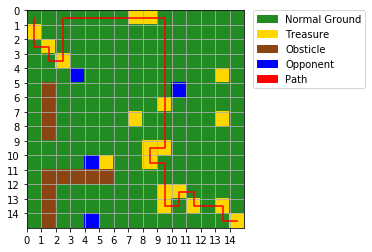

In [11]:
def walk(start, goal, Q, M, max_steps):
    M_copy = np.copy(M)

    cmap = mpl.colors.ListedColormap(['forestgreen', 'gold', 'saddlebrown', 'blue'])

    M[abs(M - NORMAL) < .01] = -10
    M[abs(M - TREASURE) < .01] = -9
    M[abs(M - OBSTICLE) < .01] = -8
    M[abs(M - OPPONENT) < .01] = -7

    M[M is -10] = 0
    M[M is -9] = 1
    M[M is -8] = 2
    M[M is -7] = 3

    plt.pcolormesh(M, cmap=cmap)

    green_patch = mpl.patches.Patch(color='forestgreen', label='Normal Ground')
    gold_patch = mpl.patches.Patch(color='gold', label='Treasure')
    brown_patch = mpl.patches.Patch(color='saddlebrown', label='Obsticle')
    blue_patch = mpl.patches.Patch(color='blue', label='Opponent')
    red_patch = mpl.patches.Patch(color='red', label='Path')
    plt.subplots_adjust(right=0.7)
    plt.legend(handles=[green_patch, gold_patch, brown_patch, blue_patch, red_patch] ,loc='upper left', bbox_to_anchor=(1.04,1), borderaxespad=0)


    steps = 1
    curr = start
    curr_x, curr_y = stateToXY(curr)
    points = M_copy[curr_y][curr_x]
    M_copy[curr_y][curr_x] = OBSTICLE
    print(str((curr_x,curr_y)), end="")
    path = [[.5,.5]]
    while curr != goal and steps < max_steps:
        next_m = get_best_next_move(curr, M_copy, Q)
        if next_m is None:
            break
        next = move_state(curr,next_m)
        curr_x, curr_y = stateToXY(curr)
        x, y = stateToXY(next)
        path.append([x+.5,y+.5])
        # print(next)
        print("->" + str((x,y)), end="")
        points += M_copy[y,x]
        M_copy[y][x] = OBSTICLE

        curr = next
        steps += 1
        
    data = np.array(path)
    plt.plot(*data.T, color='red')

    plt.axes().set_aspect('equal') #set the x and y axes to the same scale
    plt.xticks(np.arange(0, len(M), 1)) # remove the tick marks by setting to an empty list
    plt.yticks(np.arange(0, len(M[0]), 1)) # remove the tick marks by setting to an empty list
    plt.grid()
    plt.axes().invert_yaxis() #invert the y-axis so the first row of data is at the top

    plt.show()

    
train(M, Q, gamma, lrn_rate, final_state, state_count, max_epochs, 0, max_steps)


print("Path from", stateToXY(start_state), "to", stateToXY(final_state))
walk(start_state, final_state, Q, M, max_steps)